# WALMART SALES FORECASTING

## Problem Statement

### The objective is predicting store sales using historicalmarkdown data.

### We are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and we are tasked to predict the department-wide sales for each store.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_percentage_error

import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#from stldecompose import decompose, forecast
#from stldecompose.forecast_funcs import drift

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
features=pd.read_csv('data/features.csv')

In [3]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
stores=pd.read_csv('data/stores.csv')

In [5]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
train=pd.read_csv('data/train.csv')

In [7]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [8]:
test=pd.read_csv('data/test.csv')

In [9]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [11]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [14]:
features_stores=pd.merge(left=features,right=stores,how='left',on='Store')

In [15]:
features_stores.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [16]:
train_final=pd.merge(left=train,right=features_stores,how='left',on=['Store','Date','IsHoliday'])

In [17]:
train_final.shape

(421570, 16)

In [18]:
train_final.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [19]:
test_final=pd.merge(left=test,right=features_stores,how='left',on=['Store','Date','IsHoliday'])

In [20]:
test_final.shape

(115064, 15)

In [21]:
train_final.Date=pd.to_datetime(train_final.Date)

In [22]:
train_final.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
dtype: object

In [23]:
test_final.Date=pd.to_datetime(test_final.Date)

In [24]:
test_final.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
dtype: object

### Adding some extra derived variables

In [25]:
train_final['month']=train_final['Date'].dt.month
train_final['week_of_year']=train_final['Date'].dt.weekofyear
train_final['year']=train_final['Date'].dt.year

In [26]:
test_final['month']=test_final['Date'].dt.month
test_final['week_of_year']=test_final['Date'].dt.weekofyear
test_final['year']=test_final['Date'].dt.year

## Handling Missings

In [27]:
train_final.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
month                0
week_of_year         0
year                 0
dtype: int64

In [28]:
test_final.isna().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
month               0
week_of_year        0
year                0
dtype: int64

In [29]:
#replacing Nan values of Markdowns to 0 in train_final
for i in ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']:
    train_final[i].fillna(0,inplace=True)
#replacing Nan values of Markdowns to 0 in test_final
for i in ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']:
    test_final[i].fillna(0,inplace=True)
for i in ['Unemployment','CPI']:
    test_final[i].fillna(test_final[i].mean(),inplace=True)

## Handling Categorical Features : Encoding

In [30]:
train_final.dtypes[train_final.dtypes=='object']

Type    object
dtype: object

In [31]:
type_dummies_train=pd.get_dummies(train_final['Type'],prefix='Type')
type_dummies_test=pd.get_dummies(test_final['Type'],prefix='Type')

In [32]:
holidays=pd.DataFrame()
holidays['super_bowl']=np.where(((train_final['Date']=='2010-02-12') | 
          (train_final['Date']=='2011-02-11')| 
          (train_final['Date']=='2012-02-10')| 
          (train_final['Date']=='2013-02-08')),1,0)
holidays['labor_day']=np.where(((train_final['Date']=='2010-09-10') | 
          (train_final['Date']=='2011-09-09')| 
          (train_final['Date']=='2012-09-07')| 
          (train_final['Date']=='2013-09-06')),1,0)
holidays['thanksgiving']=np.where(((train_final['Date']=='2010-11-26') | 
          (train_final['Date']=='2011-11-25')| 
          (train_final['Date']=='2012-11-23')| 
          (train_final['Date']=='2013-11-29')),1,0)
holidays['christmas']=np.where(((train_final['Date']=='2010-12-31') | 
          (train_final['Date']=='2011-12-30')| 
          (train_final['Date']=='2012-12-28')| 
          (train_final['Date']=='2013-12-27')),1,0)

In [33]:
holidays_test=pd.DataFrame()
holidays_test['super_bowl']=np.where(((test_final['Date']=='2010-02-12') | 
          (test_final['Date']=='2011-02-11')| 
          (test_final['Date']=='2012-02-10')| 
          (test_final['Date']=='2013-02-08')),1,0)
holidays_test['labor_day']=np.where(((test_final['Date']=='2010-09-10') | 
          (test_final['Date']=='2011-09-09')| 
          (test_final['Date']=='2012-09-07')| 
          (test_final['Date']=='2013-09-06')),1,0)
holidays_test['thanksgiving']=np.where(((test_final['Date']=='2010-11-26') | 
          (test_final['Date']=='2011-11-25')| 
          (test_final['Date']=='2012-11-23')| 
          (test_final['Date']=='2013-11-29')),1,0)
holidays_test['christmas']=np.where(((test_final['Date']=='2010-12-31') | 
          (test_final['Date']=='2011-12-30')| 
          (test_final['Date']=='2012-12-28')| 
          (test_final['Date']=='2013-12-27')),1,0)

In [34]:
train_final=pd.concat([train_final,type_dummies_train,holidays],axis=1)

In [35]:
test_final=pd.concat([test_final,type_dummies_test,holidays_test],axis=1)

In [36]:
train_final.drop(columns=['Type','IsHoliday'],inplace=True)

In [37]:
test_final.drop(columns=['Type','IsHoliday'],inplace=True)

In [38]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   Temperature   421570 non-null  float64       
 5   Fuel_Price    421570 non-null  float64       
 6   MarkDown1     421570 non-null  float64       
 7   MarkDown2     421570 non-null  float64       
 8   MarkDown3     421570 non-null  float64       
 9   MarkDown4     421570 non-null  float64       
 10  MarkDown5     421570 non-null  float64       
 11  CPI           421570 non-null  float64       
 12  Unemployment  421570 non-null  float64       
 13  Size          421570 non-null  int64         
 14  month         421570 non-null  int64         
 15  week_of_year  421

In [39]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         115064 non-null  int64         
 1   Dept          115064 non-null  int64         
 2   Date          115064 non-null  datetime64[ns]
 3   Temperature   115064 non-null  float64       
 4   Fuel_Price    115064 non-null  float64       
 5   MarkDown1     115064 non-null  float64       
 6   MarkDown2     115064 non-null  float64       
 7   MarkDown3     115064 non-null  float64       
 8   MarkDown4     115064 non-null  float64       
 9   MarkDown5     115064 non-null  float64       
 10  CPI           115064 non-null  float64       
 11  Unemployment  115064 non-null  float64       
 12  Size          115064 non-null  int64         
 13  month         115064 non-null  int64         
 14  week_of_year  115064 non-null  int64         
 15  year          115

In [40]:
#creating deep copy of our dataframes for futher use
train_forecast=train_final.copy()
test_forecast=test_final.copy()

## EDA

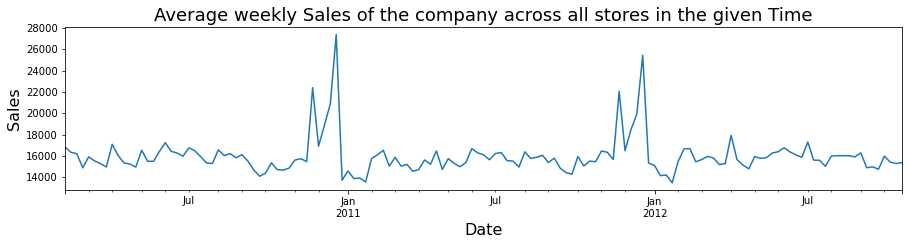

In [41]:
plt.figure(figsize=(15,3))
train_final.groupby('Date')['Weekly_Sales'].mean().plot()
plt.title('Average weekly Sales of the company across all stores in the given Time', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

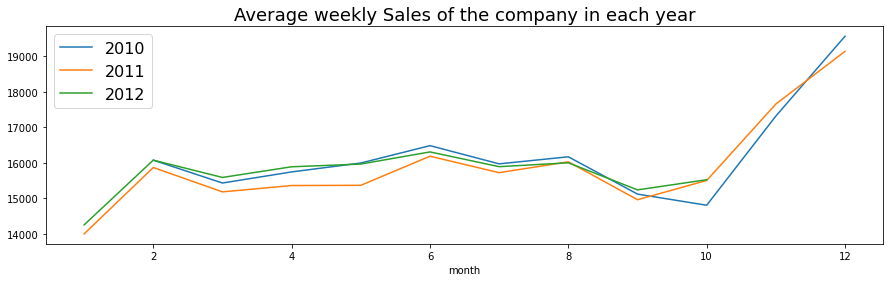

In [42]:
plt.figure(figsize=(15,4))
(train_final[train_final.year==2010]).groupby('month')['Weekly_Sales'].mean().plot()
(train_final[train_final.year==2011]).groupby('month')['Weekly_Sales'].mean().plot()
(train_final[train_final.year==2012]).groupby('month')['Weekly_Sales'].mean().plot()
plt.title('Average weekly Sales of the company in each year', fontsize=18)
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.show()

<Figure size 1080x288 with 0 Axes>

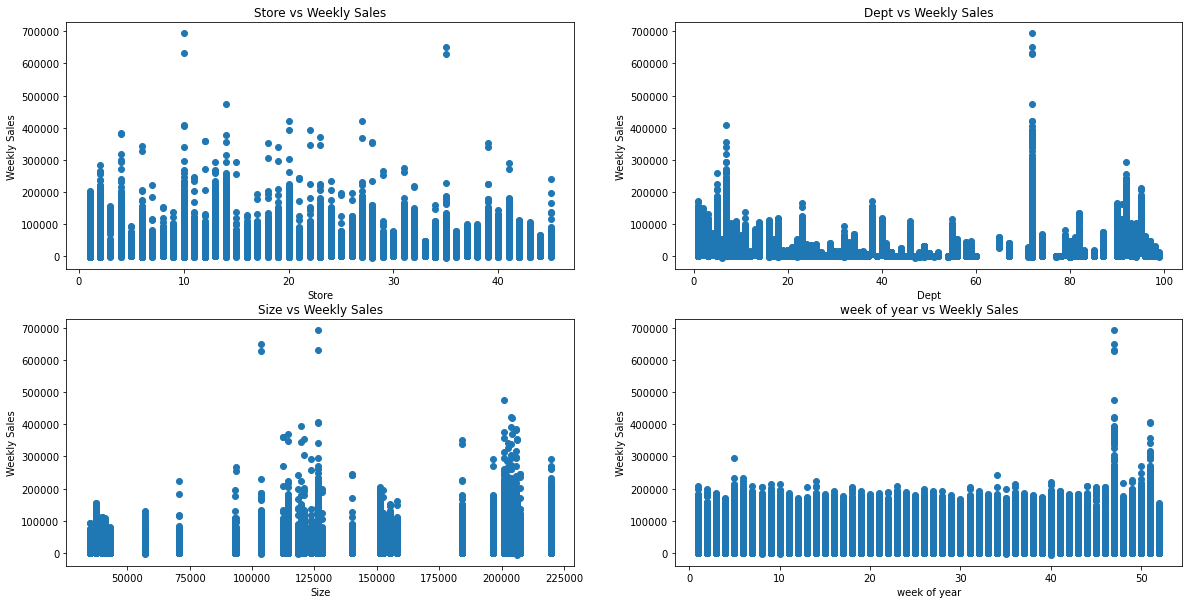

In [43]:
plt.figure(figsize=(15,4))
fig, ax = plt.subplots(2, 2)
fig.set_figwidth(20)
fig.set_figheight(10)

ax[0][0].scatter(train_final['Store'],train_final['Weekly_Sales'])
ax[0][0].set_xlabel("Store")
ax[0][0].set_ylabel("Weekly Sales")
ax[0][0].set_title("Store vs Weekly Sales")

ax[0][1].scatter(train_final['Dept'],train_final['Weekly_Sales'])
ax[0][1].set_xlabel("Dept")
ax[0][1].set_ylabel("Weekly Sales")
ax[0][1].set_title("Dept vs Weekly Sales")

ax[1][0].scatter(train_final['Size'],train_final['Weekly_Sales'])
ax[1][0].set_xlabel("Size")
ax[1][0].set_ylabel("Weekly Sales")
ax[1][0].set_title("Size vs Weekly Sales")

ax[1][1].scatter(train_final['week_of_year'],train_final['Weekly_Sales'])
ax[1][1].set_xlabel("week of year")
ax[1][1].set_ylabel("Weekly Sales")
ax[1][1].set_title("week of year vs Weekly Sales")

plt.show()

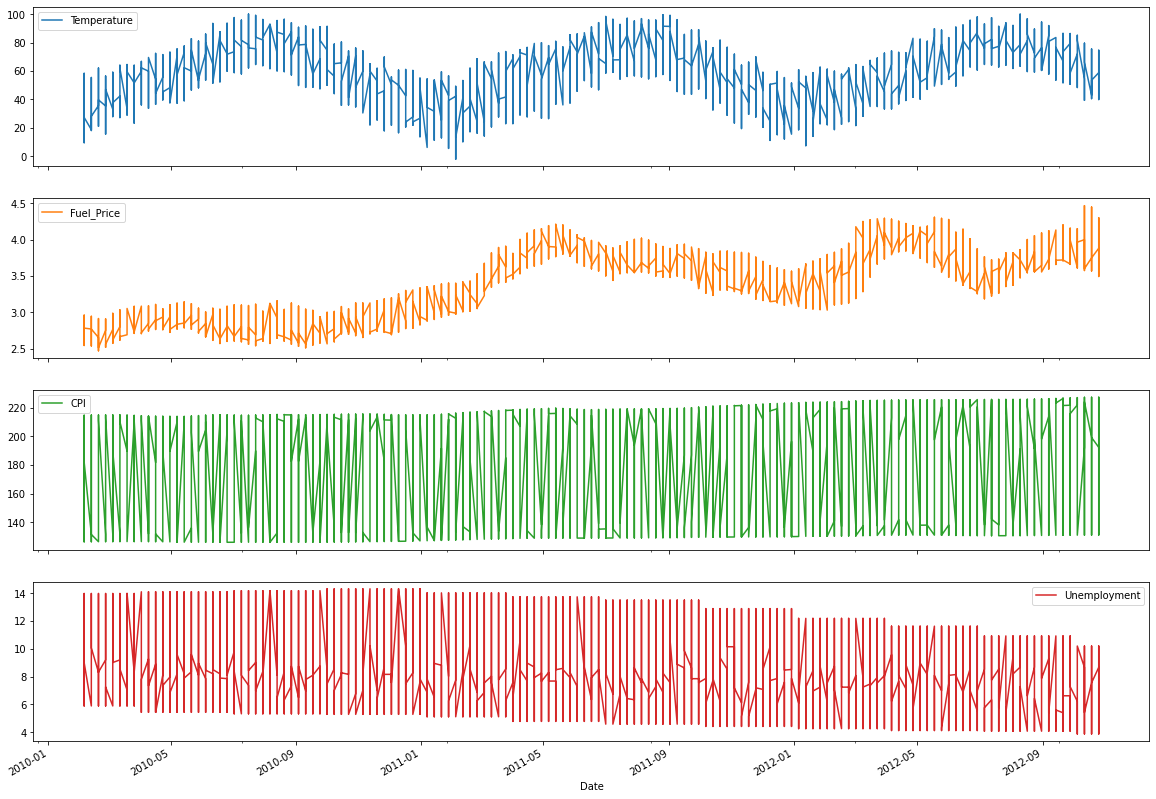

In [44]:
train_final[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].plot(x='Date', subplots=True, figsize=(20,15))
plt.show()

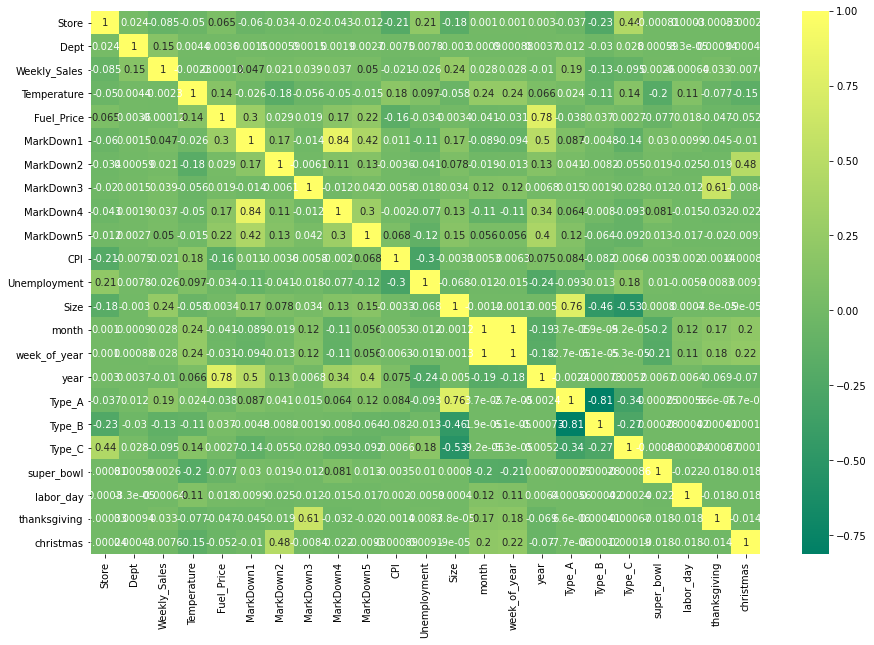

In [45]:
plt.figure(figsize=(15,10))
sns.heatmap(train_final.corr(),annot=True,cmap='summer')
plt.show()

# Modelling

### Train Test Split

In [46]:
#train test split
X_train, X_test, y_train, y_test=train_test_split(
    (train_final.drop(columns=['Weekly_Sales','Date'])),train_final['Weekly_Sales'],test_size=0.3,random_state=101)

### Grid Search Cross Validation

In [47]:
# params= {'n_estimators': [50,100,150,200],
#                'max_features': [4,5,6,7,8,9],
#                'max_depth': [25,30,35,40,45]}

In [48]:
# grid_rf=GridSearchCV(RandomForestRegressor(),
#                     param_grid=params,
#                     cv=2,verbose=True)

In [49]:
# grid_rf=grid_rf.fit(X_train,y_train)

In [50]:
# grid_rf.best_params_

## Random Forest Regressor

In [51]:
#model initialization
rf=RandomForestRegressor()

In [52]:
rf=rf.fit(X_train,y_train)

In [53]:
#train_accuracy
train_accuracy=r2_score(y_train,rf.predict(X_train))

In [54]:
#test_accuracy
test_accuracy=r2_score(y_test,rf.predict(X_test))

In [55]:
print('Training Accuracy Score : ',train_accuracy)
print('Testing Accuracy Score : ',test_accuracy)

Training Accuracy Score :  0.9963776772206769
Testing Accuracy Score :  0.9740774332568203


In [56]:
rf_accuracy=pd.DataFrame(data=[train_accuracy,test_accuracy],index=['Train Accuracy','Test Accuracy'])

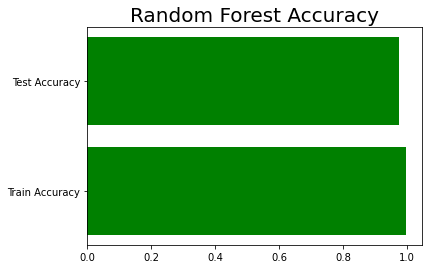

In [57]:
plt.barh(rf_accuracy.index,width=rf_accuracy[0],color='green')
plt.title('Random Forest Accuracy',fontsize=20)
plt.show()

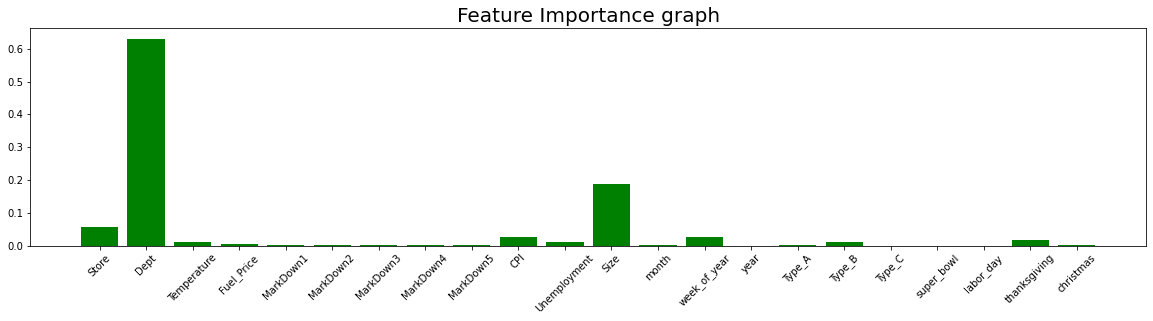

In [58]:
plt.figure(figsize=(20,4))
feat_imp = rf.feature_importances_
plt.bar(X_train.columns,feat_imp,color='green')
plt.title('Feature Importance graph',fontsize=20)
plt.xticks(rotation=45)
plt.show()

In [59]:
rf_test_pred=rf.predict(test_final.drop(columns=['Date']))

In [60]:
rf_test_pred

array([30898.0564, 19390.3044, 18066.6705, ...,   572.7137,   575.4833,
         582.3975])

In [61]:
result_df=pd.read_csv('data/sampleSubmission.csv')

In [62]:
result_df['weekly_sales_rf']=rf_test_pred

In [63]:
result_df

,Id,Weekly_Sales,weekly_sales_rf
0,1_1_2012-11-02,0,30898.0564
1,1_1_2012-11-09,0,19390.3044
2,1_1_2012-11-16,0,18066.6705
3,1_1_2012-11-23,0,19033.9159
4,1_1_2012-11-30,0,20327.6479
...,...,...,...
115059,45_98_2013-06-28,0,559.2585
115060,45_98_2013-07-05,0,594.0507
115061,45_98_2013-07-12,0,572.7137
115062,45_98_2013-07-19,0,575.4833


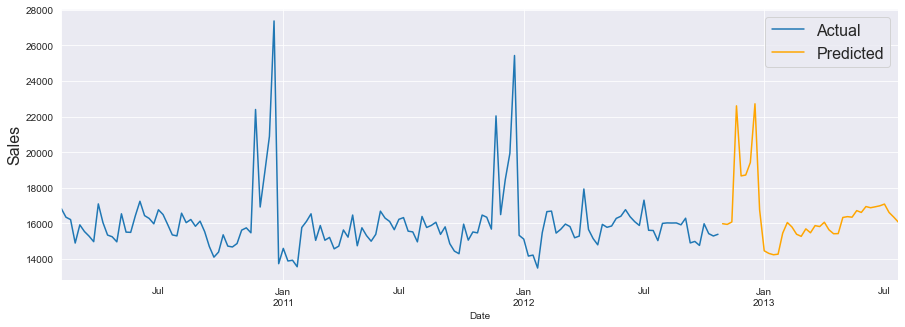

In [64]:
sns.set_style('darkgrid')
plt.figure(figsize=(15,5))
test_final['Weekly_Sales_pred'] = rf_test_pred
train_final.groupby('Date')['Weekly_Sales'].mean().plot()
test_final.groupby('Date')['Weekly_Sales_pred'].mean().plot(color='orange')
plt.legend(['Actual', 'Predicted'], loc='best', fontsize=16)
plt.ylabel('Sales', fontsize=16);

## Moving Averages

In [65]:
sales=train_forecast.groupby('Date')['Weekly_Sales'].mean()

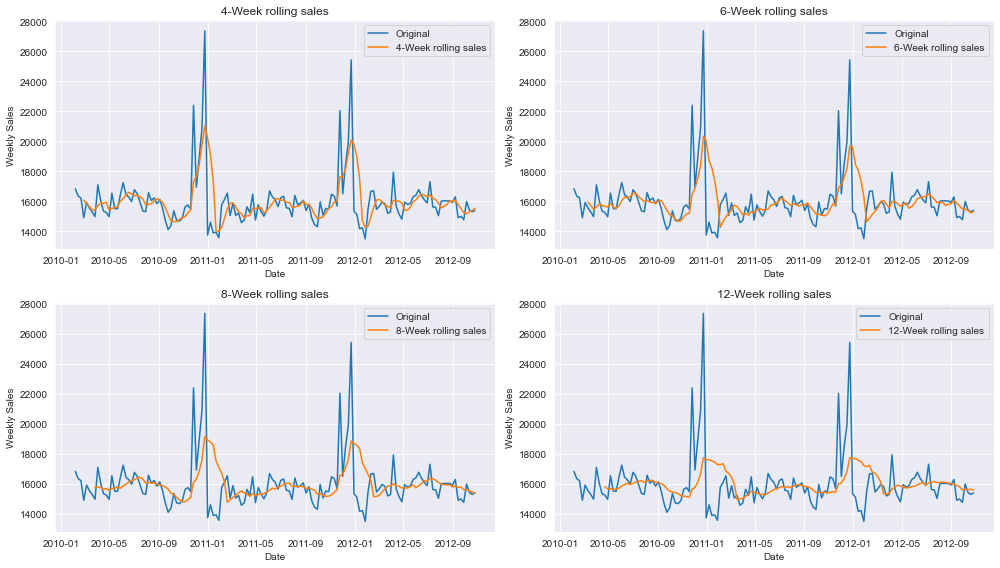

In [66]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(sales.index, sales, label='Original')
axes[0][0].plot(sales.index, sales.rolling(window=4).mean(), label='4-Week rolling sales')
axes[0][0].set_xlabel("Date")
axes[0][0].set_ylabel("Weekly Sales")
axes[0][0].set_title("4-Week rolling sales")
axes[0][0].legend(loc='best')

axes[0][1].plot(sales.index, sales, label='Original')
axes[0][1].plot(sales.index, sales.rolling(window=6).mean(), label='6-Week rolling sales')
axes[0][1].set_xlabel("Date")
axes[0][1].set_ylabel("Weekly Sales")
axes[0][1].set_title("6-Week rolling sales")
axes[0][1].legend(loc='best')

axes[1][0].plot(sales.index, sales, label='Original')
axes[1][0].plot(sales.index, sales.rolling(window=8).mean(), label='8-Week rolling sales')
axes[1][0].set_xlabel("Date")
axes[1][0].set_ylabel("Weekly Sales")
axes[1][0].set_title("8-Week rolling sales")
axes[1][0].legend(loc='best')

axes[1][1].plot(sales.index, sales, label='Original')
axes[1][1].plot(sales.index, sales.rolling(window=12).mean(), label='12-Week rolling sales')
axes[1][1].set_xlabel("Date")
axes[1][1].set_ylabel("Weekly Sales")
axes[1][1].set_title("12-Week rolling sales")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

# Decomposotion of Timeseries

In [67]:
#using the other deep copy of data so that we get complete data to work upon

In [68]:
train_forecast.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,month,week_of_year,year,Type_A,Type_B,Type_C,super_bowl,labor_day,thanksgiving,christmas
0,1,1,2010-02-05,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,...,2,5,2010,1,0,0,0,0,0,0
1,1,1,2010-02-12,46039.49,38.51,2.548,0.0,0.0,0.0,0.0,...,2,6,2010,1,0,0,1,0,0,0
2,1,1,2010-02-19,41595.55,39.93,2.514,0.0,0.0,0.0,0.0,...,2,7,2010,1,0,0,0,0,0,0
3,1,1,2010-02-26,19403.54,46.63,2.561,0.0,0.0,0.0,0.0,...,2,8,2010,1,0,0,0,0,0,0
4,1,1,2010-03-05,21827.90,46.50,2.625,0.0,0.0,0.0,0.0,...,3,9,2010,1,0,0,0,0,0,0


In [69]:
test_forecast.head()

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,month,week_of_year,year,Type_A,Type_B,Type_C,super_bowl,labor_day,thanksgiving,christmas
0,1,1,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,...,11,44,2012,1,0,0,0,0,0,0
1,1,1,2012-11-09,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,...,11,45,2012,1,0,0,0,0,0,0
2,1,1,2012-11-16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,...,11,46,2012,1,0,0,0,0,0,0
3,1,1,2012-11-23,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,...,11,47,2012,1,0,0,0,0,1,0
4,1,1,2012-11-30,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,...,11,48,2012,1,0,0,0,0,0,0


In [70]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
train_forecast.set_index('Date',inplace=True)
test_forecast.set_index('Date',inplace=True)

In [71]:
train_forecast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   Temperature   421570 non-null  float64
 4   Fuel_Price    421570 non-null  float64
 5   MarkDown1     421570 non-null  float64
 6   MarkDown2     421570 non-null  float64
 7   MarkDown3     421570 non-null  float64
 8   MarkDown4     421570 non-null  float64
 9   MarkDown5     421570 non-null  float64
 10  CPI           421570 non-null  float64
 11  Unemployment  421570 non-null  float64
 12  Size          421570 non-null  int64  
 13  month         421570 non-null  int64  
 14  week_of_year  421570 non-null  int64  
 15  year          421570 non-null  int64  
 16  Type_A        421570 non-null  uint8  
 17  Type_B        421570 non-null  u

In [72]:
decomp=seasonal_decompose(train_forecast.groupby('Date')['Weekly_Sales'].mean(),model='multiplicative',extrapolate_trend=8)

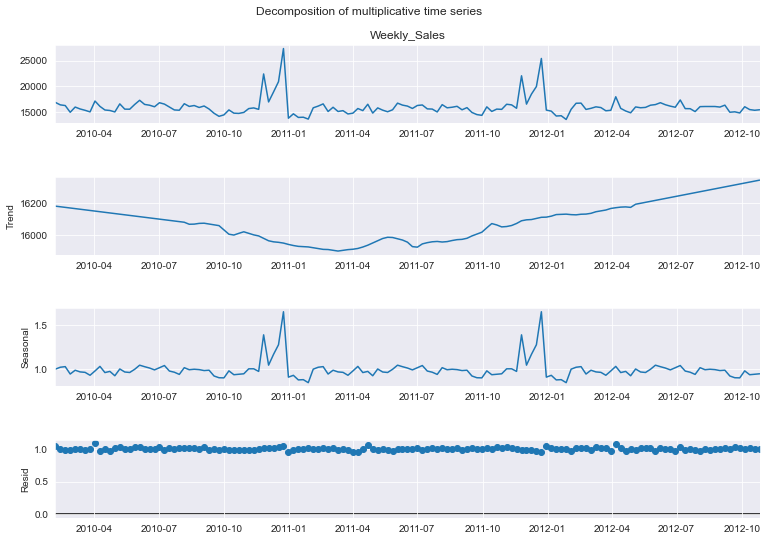

In [73]:
fig = decomp.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

In [74]:

decomp_data=pd.concat([decomp.trend,
                      decomp.seasonal,
                      decomp.resid,
                       decomp.observed,
                      (decomp.trend*decomp.seasonal*decomp.resid)],axis=1)
decomp_data.columns=['Trend','Seasonality','Irregular','Actual','Forecasted']

In [75]:
decomp_data

,Trend,Seasonality,Irregular,Actual,Forecasted
Date,,,,,
2010-02-05,16182.604209,0.997278,1.043224,16836.121997,16836.121997
2010-02-12,16178.764063,1.019058,0.991810,16352.056032,16352.056032
2010-02-19,16174.923918,1.026008,0.977166,16216.658979,16216.658979
2010-02-26,16171.083773,0.942126,0.977969,14899.549688,14899.549688
2010-03-05,16167.243627,0.985161,0.999603,15921.015727,15921.015727
...,...,...,...,...,...
2012-09-28,16320.433449,0.898607,1.006797,14765.327279,14765.327279
2012-10-05,16326.437634,0.978108,1.000901,15983.413747,15983.413747
2012-10-12,16332.441819,0.934335,1.010985,15427.596739,15427.596739


## Stationarity of Time Series for ARIMA/SARIMA Models

##### Dickey-Fuller Test

In [76]:
sales=train_forecast.groupby('Date')['Weekly_Sales'].mean()

In [77]:
type(sales)

pandas.core.series.Series

<AxesSubplot:xlabel='Date'>

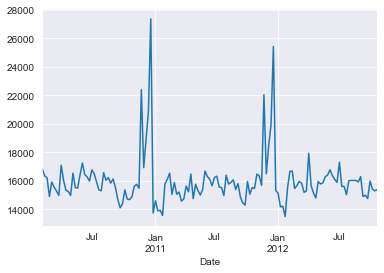

In [78]:
sales.plot()

In [79]:
adfuller(sales)

(-5.930802744748689,
 2.3832272706105368e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.7748547116485)

In [80]:
def adf(ts):
    adf_res=adfuller(ts.dropna())
    print('Results of Dickey-Fuller Test:')
    adfoutput = pd.Series(adf_res[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    print(adfoutput)
    ts.plot()
    plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -5.930803e+00
p-value                        2.383227e-07
#lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
dtype: float64


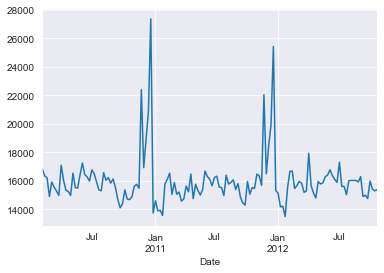

In [81]:
adf(sales)

Results of Dickey-Fuller Test:
Test Statistic                -6.359255e+00
p-value                        2.497971e-08
#lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
dtype: float64


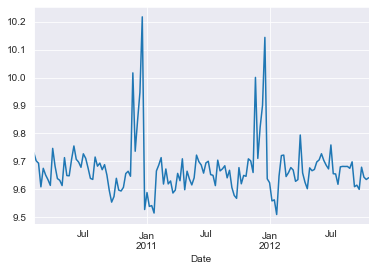

In [82]:
adf(np.log(sales))

Results of Dickey-Fuller Test:
Test Statistic                -6.684617e+00
p-value                        4.256972e-09
#lags Used                     7.000000e+00
Number of Observations Used    1.340000e+02
dtype: float64


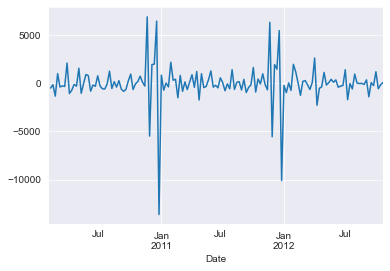

In [83]:
adf(sales.diff(1))

Results of Dickey-Fuller Test:
Test Statistic                -7.212928e+00
p-value                        2.210682e-10
#lags Used                     4.000000e+00
Number of Observations Used    1.360000e+02
dtype: float64


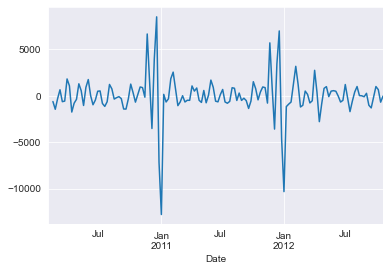

In [84]:
adf(sales.diff(2))

Results of Dickey-Fuller Test:
Test Statistic                -7.475684e+00
p-value                        4.920938e-11
#lags Used                     4.000000e+00
Number of Observations Used    1.360000e+02
dtype: float64


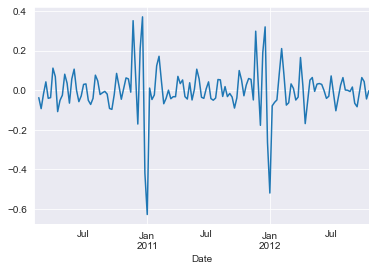

In [85]:
adf((np.log(sales)).diff(2))

## Plotting Auto Correlation Funtion and Partial Auto Correlation Funtion to find the values of p and q

In [86]:
sales_log_diff2=((np.log(sales)).diff(2).dropna())

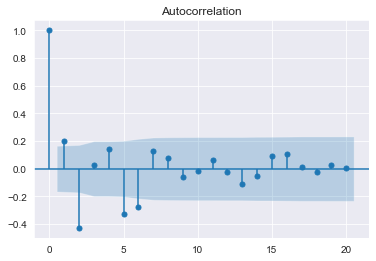

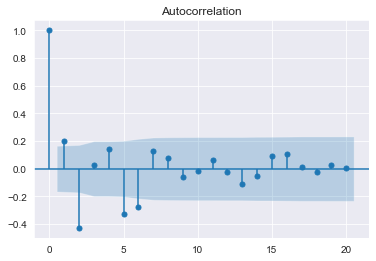

In [87]:
smt.graphics.plot_acf(sales_log_diff2, lags=20)

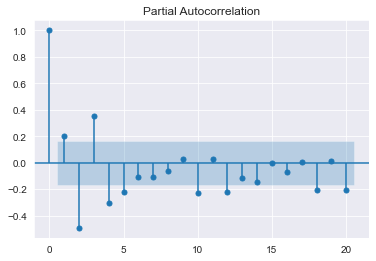

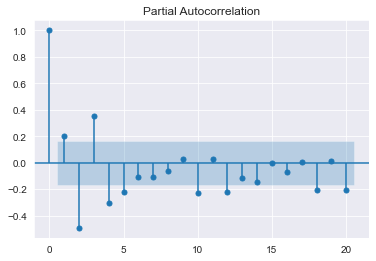

In [88]:
smt.graphics.plot_pacf(sales_log_diff2, lags=20)

#### So, we found our ARIMA/SARIMA parameters, p=1, q=1, d=2 and we have to use SARIMA because there is still some seasonlity left in our data

### Trying to perform SARIMAX on 1st combination of Store and Department

In [89]:
store1_dep1_train=train_forecast[(train_forecast['Store']==1)&(train_forecast['Dept']==1)]

In [90]:
store1_dep1_test=test_forecast[(test_forecast['Store']==1)&(test_forecast['Dept']==1)]

In [91]:
model=SARIMAX(endog=(store1_dep1_train['Weekly_Sales']),exog=(store1_dep1_train.drop(columns=['Store','Dept','Weekly_Sales'])),
              order=(1,2,1),seasonal_order=(1,0,1,12), enforce_stationarity=False,
                           enforce_invertibility=False)

In [92]:
model=model.fit()

In [93]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 2, 1)x(1, 0, 1, 12)   Log Likelihood               -1321.928
Date:                            Sat, 26 Jun 2021   AIC                           2693.856
Time:                                    14:14:11   BIC                           2764.961
Sample:                                02-05-2010   HQIC                          2722.745
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Temperature      9.1348    245.433      0.037      0.970    -471.905     490.175
Fuel_Price    5000.7878   3.1

In [94]:
model.forecast(steps=len(store1_dep1_test),exog=(store1_dep1_test.drop(columns=['Store','Dept'])))

2012-11-02     29673.463321
2012-11-09     24326.567262
2012-11-16     21214.018851
2012-11-23     10168.677035
2012-11-30     18777.119714
2012-12-07     19778.295004
2012-12-14     23919.009351
2012-12-21     21088.542431
2012-12-28     -7420.139107
2013-01-04    -27224.165239
2013-01-11    -33730.821698
2013-01-18    -38805.602047
2013-01-25    -40303.692259
2013-02-01    -35648.111747
2013-02-08    -43140.280696
2013-02-15    -51369.176062
2013-02-22    -42710.350253
2013-03-01    -40480.110064
2013-03-08    -41607.188404
2013-03-15    -41339.545165
2013-03-22    -44216.806195
2013-03-29    -47664.423956
2013-04-05    -34066.510266
2013-04-12    -34230.573781
2013-04-19    -35440.568595
2013-04-26    -35866.655662
2013-05-03    107579.244006
2013-05-10    101606.146896
2013-05-17    100641.653177
2013-05-24    103549.413718
2013-05-31    103987.839062
2013-06-07    104008.879701
2013-06-14    104141.625413
2013-06-21    103059.236891
2013-06-28    102316.387377
2013-07-05    107953

## Automating the process for each combination of Store and Department

In [95]:
res=pd.Series()
for x,y in test_forecast.groupby(["Store", "Dept"]):
    train_model=train_forecast[(train_forecast['Store']==x[0])&(train_forecast['Dept']==x[1])]
    test_model=test_forecast[(test_forecast['Store']==x[0])&(test_forecast['Dept']==x[1])]
    print('Predicting for Store = '+str(x[0])+' and Dept = '+str(x[1]))

    try:
        if len(test_model)<1:
            continue
        else:
            sarimax=SARIMAX(endog=(train_model['Weekly_Sales']),exog=(train_model.drop(columns=['Store','Dept','Weekly_Sales'])),
                      order=(1,2,1),seasonal_order=(1,0,1,12), enforce_stationarity=False,
                                   enforce_invertibility=False)

            sarimax=sarimax.fit()

            pred=(sarimax.forecast(exog=(test_model.drop(columns=['Store','Dept'])),steps=len(test_model)))

            res=pd.concat([res,pred])
            
            pred=pd.Series()
    except:
        forec=train_model['Weekly_Sales'].mean()
        temp=[forec]*len(test_model)
        temp_ser=pd.Series(index=test_model.index,data=temp)
        res=pd.concat([res,temp_ser])
        temp=[]
        temp_ser=pd.Series()
            

Predicting for Store = 1 and Dept = 1
Predicting for Store = 1 and Dept = 2
Predicting for Store = 1 and Dept = 3
Predicting for Store = 1 and Dept = 4
Predicting for Store = 1 and Dept = 5
Predicting for Store = 1 and Dept = 6
Predicting for Store = 1 and Dept = 7
Predicting for Store = 1 and Dept = 8
Predicting for Store = 1 and Dept = 9
Predicting for Store = 1 and Dept = 10
Predicting for Store = 1 and Dept = 11
Predicting for Store = 1 and Dept = 12
Predicting for Store = 1 and Dept = 13
Predicting for Store = 1 and Dept = 14
Predicting for Store = 1 and Dept = 16
Predicting for Store = 1 and Dept = 17
Predicting for Store = 1 and Dept = 18
Predicting for Store = 1 and Dept = 19
Predicting for Store = 1 and Dept = 20
Predicting for Store = 1 and Dept = 21
Predicting for Store = 1 and Dept = 22
Predicting for Store = 1 and Dept = 23
Predicting for Store = 1 and Dept = 24
Predicting for Store = 1 and Dept = 25
Predicting for Store = 1 and Dept = 26
Predicting for Store = 1 and Dept 

Predicting for Store = 3 and Dept = 94
Predicting for Store = 3 and Dept = 95
Predicting for Store = 3 and Dept = 96
Predicting for Store = 3 and Dept = 97
Predicting for Store = 3 and Dept = 98
Predicting for Store = 4 and Dept = 1
Predicting for Store = 4 and Dept = 2
Predicting for Store = 4 and Dept = 3
Predicting for Store = 4 and Dept = 4
Predicting for Store = 4 and Dept = 5
Predicting for Store = 4 and Dept = 6
Predicting for Store = 4 and Dept = 7
Predicting for Store = 4 and Dept = 8
Predicting for Store = 4 and Dept = 9
Predicting for Store = 4 and Dept = 10
Predicting for Store = 4 and Dept = 11
Predicting for Store = 4 and Dept = 12
Predicting for Store = 4 and Dept = 13
Predicting for Store = 4 and Dept = 14
Predicting for Store = 4 and Dept = 16
Predicting for Store = 4 and Dept = 17
Predicting for Store = 4 and Dept = 18
Predicting for Store = 4 and Dept = 19
Predicting for Store = 4 and Dept = 20
Predicting for Store = 4 and Dept = 21
Predicting for Store = 4 and Dept 

Predicting for Store = 6 and Dept = 83
Predicting for Store = 6 and Dept = 85
Predicting for Store = 6 and Dept = 87
Predicting for Store = 6 and Dept = 90
Predicting for Store = 6 and Dept = 91
Predicting for Store = 6 and Dept = 92
Predicting for Store = 6 and Dept = 93
Predicting for Store = 6 and Dept = 94
Predicting for Store = 6 and Dept = 95
Predicting for Store = 6 and Dept = 96
Predicting for Store = 6 and Dept = 97
Predicting for Store = 6 and Dept = 98
Predicting for Store = 6 and Dept = 99
Predicting for Store = 7 and Dept = 1
Predicting for Store = 7 and Dept = 2
Predicting for Store = 7 and Dept = 3
Predicting for Store = 7 and Dept = 4
Predicting for Store = 7 and Dept = 5
Predicting for Store = 7 and Dept = 6
Predicting for Store = 7 and Dept = 7
Predicting for Store = 7 and Dept = 8
Predicting for Store = 7 and Dept = 9
Predicting for Store = 7 and Dept = 10
Predicting for Store = 7 and Dept = 11
Predicting for Store = 7 and Dept = 12
Predicting for Store = 7 and Dept 

Predicting for Store = 9 and Dept = 72
Predicting for Store = 9 and Dept = 74
Predicting for Store = 9 and Dept = 79
Predicting for Store = 9 and Dept = 80
Predicting for Store = 9 and Dept = 81
Predicting for Store = 9 and Dept = 82
Predicting for Store = 9 and Dept = 85
Predicting for Store = 9 and Dept = 87
Predicting for Store = 9 and Dept = 90
Predicting for Store = 9 and Dept = 91
Predicting for Store = 9 and Dept = 92
Predicting for Store = 9 and Dept = 94
Predicting for Store = 9 and Dept = 95
Predicting for Store = 9 and Dept = 96
Predicting for Store = 9 and Dept = 98
Predicting for Store = 9 and Dept = 99
Predicting for Store = 10 and Dept = 1
Predicting for Store = 10 and Dept = 2
Predicting for Store = 10 and Dept = 3
Predicting for Store = 10 and Dept = 4
Predicting for Store = 10 and Dept = 5
Predicting for Store = 10 and Dept = 6
Predicting for Store = 10 and Dept = 7
Predicting for Store = 10 and Dept = 8
Predicting for Store = 10 and Dept = 9
Predicting for Store = 10

Predicting for Store = 12 and Dept = 49
Predicting for Store = 12 and Dept = 52
Predicting for Store = 12 and Dept = 54
Predicting for Store = 12 and Dept = 55
Predicting for Store = 12 and Dept = 56
Predicting for Store = 12 and Dept = 58
Predicting for Store = 12 and Dept = 59
Predicting for Store = 12 and Dept = 60
Predicting for Store = 12 and Dept = 67
Predicting for Store = 12 and Dept = 71
Predicting for Store = 12 and Dept = 72
Predicting for Store = 12 and Dept = 74
Predicting for Store = 12 and Dept = 79
Predicting for Store = 12 and Dept = 80
Predicting for Store = 12 and Dept = 81
Predicting for Store = 12 and Dept = 82
Predicting for Store = 12 and Dept = 83
Predicting for Store = 12 and Dept = 85
Predicting for Store = 12 and Dept = 87
Predicting for Store = 12 and Dept = 90
Predicting for Store = 12 and Dept = 91
Predicting for Store = 12 and Dept = 92
Predicting for Store = 12 and Dept = 93
Predicting for Store = 12 and Dept = 94
Predicting for Store = 12 and Dept = 95


Predicting for Store = 15 and Dept = 30
Predicting for Store = 15 and Dept = 31
Predicting for Store = 15 and Dept = 32
Predicting for Store = 15 and Dept = 33
Predicting for Store = 15 and Dept = 34
Predicting for Store = 15 and Dept = 35
Predicting for Store = 15 and Dept = 36
Predicting for Store = 15 and Dept = 37
Predicting for Store = 15 and Dept = 38
Predicting for Store = 15 and Dept = 40
Predicting for Store = 15 and Dept = 41
Predicting for Store = 15 and Dept = 42
Predicting for Store = 15 and Dept = 44
Predicting for Store = 15 and Dept = 46
Predicting for Store = 15 and Dept = 47
Predicting for Store = 15 and Dept = 49
Predicting for Store = 15 and Dept = 50
Predicting for Store = 15 and Dept = 52
Predicting for Store = 15 and Dept = 54
Predicting for Store = 15 and Dept = 55
Predicting for Store = 15 and Dept = 56
Predicting for Store = 15 and Dept = 58
Predicting for Store = 15 and Dept = 59
Predicting for Store = 15 and Dept = 60
Predicting for Store = 15 and Dept = 67


Predicting for Store = 18 and Dept = 17
Predicting for Store = 18 and Dept = 18
Predicting for Store = 18 and Dept = 19
Predicting for Store = 18 and Dept = 20
Predicting for Store = 18 and Dept = 21
Predicting for Store = 18 and Dept = 22
Predicting for Store = 18 and Dept = 23
Predicting for Store = 18 and Dept = 24
Predicting for Store = 18 and Dept = 25
Predicting for Store = 18 and Dept = 26
Predicting for Store = 18 and Dept = 27
Predicting for Store = 18 and Dept = 28
Predicting for Store = 18 and Dept = 29
Predicting for Store = 18 and Dept = 30
Predicting for Store = 18 and Dept = 31
Predicting for Store = 18 and Dept = 32
Predicting for Store = 18 and Dept = 33
Predicting for Store = 18 and Dept = 34
Predicting for Store = 18 and Dept = 35
Predicting for Store = 18 and Dept = 36
Predicting for Store = 18 and Dept = 38
Predicting for Store = 18 and Dept = 40
Predicting for Store = 18 and Dept = 41
Predicting for Store = 18 and Dept = 42
Predicting for Store = 18 and Dept = 43


Predicting for Store = 20 and Dept = 96
Predicting for Store = 20 and Dept = 97
Predicting for Store = 20 and Dept = 98
Predicting for Store = 20 and Dept = 99
Predicting for Store = 21 and Dept = 1
Predicting for Store = 21 and Dept = 2
Predicting for Store = 21 and Dept = 3
Predicting for Store = 21 and Dept = 4
Predicting for Store = 21 and Dept = 5
Predicting for Store = 21 and Dept = 6
Predicting for Store = 21 and Dept = 7
Predicting for Store = 21 and Dept = 8
Predicting for Store = 21 and Dept = 9
Predicting for Store = 21 and Dept = 10
Predicting for Store = 21 and Dept = 11
Predicting for Store = 21 and Dept = 12
Predicting for Store = 21 and Dept = 13
Predicting for Store = 21 and Dept = 14
Predicting for Store = 21 and Dept = 16
Predicting for Store = 21 and Dept = 17
Predicting for Store = 21 and Dept = 18
Predicting for Store = 21 and Dept = 19
Predicting for Store = 21 and Dept = 20
Predicting for Store = 21 and Dept = 21
Predicting for Store = 21 and Dept = 22
Predictin

Predicting for Store = 23 and Dept = 87
Predicting for Store = 23 and Dept = 90
Predicting for Store = 23 and Dept = 91
Predicting for Store = 23 and Dept = 92
Predicting for Store = 23 and Dept = 93
Predicting for Store = 23 and Dept = 94
Predicting for Store = 23 and Dept = 95
Predicting for Store = 23 and Dept = 96
Predicting for Store = 23 and Dept = 97
Predicting for Store = 23 and Dept = 98
Predicting for Store = 23 and Dept = 99
Predicting for Store = 24 and Dept = 1
Predicting for Store = 24 and Dept = 2
Predicting for Store = 24 and Dept = 3
Predicting for Store = 24 and Dept = 4
Predicting for Store = 24 and Dept = 5
Predicting for Store = 24 and Dept = 6
Predicting for Store = 24 and Dept = 7
Predicting for Store = 24 and Dept = 8
Predicting for Store = 24 and Dept = 9
Predicting for Store = 24 and Dept = 10
Predicting for Store = 24 and Dept = 11
Predicting for Store = 24 and Dept = 12
Predicting for Store = 24 and Dept = 13
Predicting for Store = 24 and Dept = 14
Predictin

Predicting for Store = 26 and Dept = 55
Predicting for Store = 26 and Dept = 56
Predicting for Store = 26 and Dept = 59
Predicting for Store = 26 and Dept = 60
Predicting for Store = 26 and Dept = 67
Predicting for Store = 26 and Dept = 71
Predicting for Store = 26 and Dept = 72
Predicting for Store = 26 and Dept = 74
Predicting for Store = 26 and Dept = 79
Predicting for Store = 26 and Dept = 80
Predicting for Store = 26 and Dept = 81
Predicting for Store = 26 and Dept = 82
Predicting for Store = 26 and Dept = 83
Predicting for Store = 26 and Dept = 85
Predicting for Store = 26 and Dept = 87
Predicting for Store = 26 and Dept = 90
Predicting for Store = 26 and Dept = 91
Predicting for Store = 26 and Dept = 92
Predicting for Store = 26 and Dept = 93
Predicting for Store = 26 and Dept = 94
Predicting for Store = 26 and Dept = 95
Predicting for Store = 26 and Dept = 96
Predicting for Store = 26 and Dept = 97
Predicting for Store = 26 and Dept = 98
Predicting for Store = 26 and Dept = 99


Predicting for Store = 29 and Dept = 36
Predicting for Store = 29 and Dept = 38
Predicting for Store = 29 and Dept = 40
Predicting for Store = 29 and Dept = 41
Predicting for Store = 29 and Dept = 42
Predicting for Store = 29 and Dept = 44
Predicting for Store = 29 and Dept = 46
Predicting for Store = 29 and Dept = 47
Predicting for Store = 29 and Dept = 48
Predicting for Store = 29 and Dept = 49
Predicting for Store = 29 and Dept = 52
Predicting for Store = 29 and Dept = 54
Predicting for Store = 29 and Dept = 55
Predicting for Store = 29 and Dept = 56
Predicting for Store = 29 and Dept = 58
Predicting for Store = 29 and Dept = 59
Predicting for Store = 29 and Dept = 60
Predicting for Store = 29 and Dept = 67
Predicting for Store = 29 and Dept = 71
Predicting for Store = 29 and Dept = 72
Predicting for Store = 29 and Dept = 74
Predicting for Store = 29 and Dept = 79
Predicting for Store = 29 and Dept = 80
Predicting for Store = 29 and Dept = 81
Predicting for Store = 29 and Dept = 82


Predicting for Store = 32 and Dept = 36
Predicting for Store = 32 and Dept = 37
Predicting for Store = 32 and Dept = 38
Predicting for Store = 32 and Dept = 40
Predicting for Store = 32 and Dept = 41
Predicting for Store = 32 and Dept = 42
Predicting for Store = 32 and Dept = 44
Predicting for Store = 32 and Dept = 45
Predicting for Store = 32 and Dept = 46
Predicting for Store = 32 and Dept = 47
Predicting for Store = 32 and Dept = 49
Predicting for Store = 32 and Dept = 52
Predicting for Store = 32 and Dept = 54
Predicting for Store = 32 and Dept = 55
Predicting for Store = 32 and Dept = 56
Predicting for Store = 32 and Dept = 58
Predicting for Store = 32 and Dept = 59
Predicting for Store = 32 and Dept = 60
Predicting for Store = 32 and Dept = 67
Predicting for Store = 32 and Dept = 71
Predicting for Store = 32 and Dept = 72
Predicting for Store = 32 and Dept = 74
Predicting for Store = 32 and Dept = 79
Predicting for Store = 32 and Dept = 80
Predicting for Store = 32 and Dept = 81


Predicting for Store = 35 and Dept = 40
Predicting for Store = 35 and Dept = 41
Predicting for Store = 35 and Dept = 42
Predicting for Store = 35 and Dept = 44
Predicting for Store = 35 and Dept = 46
Predicting for Store = 35 and Dept = 47
Predicting for Store = 35 and Dept = 49
Predicting for Store = 35 and Dept = 52
Predicting for Store = 35 and Dept = 54
Predicting for Store = 35 and Dept = 55
Predicting for Store = 35 and Dept = 56
Predicting for Store = 35 and Dept = 58
Predicting for Store = 35 and Dept = 59
Predicting for Store = 35 and Dept = 60
Predicting for Store = 35 and Dept = 67
Predicting for Store = 35 and Dept = 71
Predicting for Store = 35 and Dept = 72
Predicting for Store = 35 and Dept = 74
Predicting for Store = 35 and Dept = 79
Predicting for Store = 35 and Dept = 80
Predicting for Store = 35 and Dept = 81
Predicting for Store = 35 and Dept = 82
Predicting for Store = 35 and Dept = 83
Predicting for Store = 35 and Dept = 85
Predicting for Store = 35 and Dept = 87


Predicting for Store = 38 and Dept = 90
Predicting for Store = 38 and Dept = 91
Predicting for Store = 38 and Dept = 92
Predicting for Store = 38 and Dept = 93
Predicting for Store = 38 and Dept = 94
Predicting for Store = 38 and Dept = 95
Predicting for Store = 38 and Dept = 96
Predicting for Store = 38 and Dept = 97
Predicting for Store = 38 and Dept = 98
Predicting for Store = 38 and Dept = 99
Predicting for Store = 39 and Dept = 1
Predicting for Store = 39 and Dept = 2
Predicting for Store = 39 and Dept = 3
Predicting for Store = 39 and Dept = 4
Predicting for Store = 39 and Dept = 5
Predicting for Store = 39 and Dept = 6
Predicting for Store = 39 and Dept = 7
Predicting for Store = 39 and Dept = 8
Predicting for Store = 39 and Dept = 9
Predicting for Store = 39 and Dept = 10
Predicting for Store = 39 and Dept = 11
Predicting for Store = 39 and Dept = 12
Predicting for Store = 39 and Dept = 13
Predicting for Store = 39 and Dept = 14
Predicting for Store = 39 and Dept = 16
Predictin

Predicting for Store = 41 and Dept = 59
Predicting for Store = 41 and Dept = 60
Predicting for Store = 41 and Dept = 67
Predicting for Store = 41 and Dept = 71
Predicting for Store = 41 and Dept = 72
Predicting for Store = 41 and Dept = 74
Predicting for Store = 41 and Dept = 79
Predicting for Store = 41 and Dept = 80
Predicting for Store = 41 and Dept = 81
Predicting for Store = 41 and Dept = 82
Predicting for Store = 41 and Dept = 83
Predicting for Store = 41 and Dept = 85
Predicting for Store = 41 and Dept = 87
Predicting for Store = 41 and Dept = 90
Predicting for Store = 41 and Dept = 91
Predicting for Store = 41 and Dept = 92
Predicting for Store = 41 and Dept = 93
Predicting for Store = 41 and Dept = 94
Predicting for Store = 41 and Dept = 95
Predicting for Store = 41 and Dept = 96
Predicting for Store = 41 and Dept = 97
Predicting for Store = 41 and Dept = 98
Predicting for Store = 41 and Dept = 99
Predicting for Store = 42 and Dept = 1
Predicting for Store = 42 and Dept = 2
Pr

Predicting for Store = 45 and Dept = 8
Predicting for Store = 45 and Dept = 9
Predicting for Store = 45 and Dept = 10
Predicting for Store = 45 and Dept = 11
Predicting for Store = 45 and Dept = 12
Predicting for Store = 45 and Dept = 13
Predicting for Store = 45 and Dept = 14
Predicting for Store = 45 and Dept = 16
Predicting for Store = 45 and Dept = 17
Predicting for Store = 45 and Dept = 18
Predicting for Store = 45 and Dept = 19
Predicting for Store = 45 and Dept = 20
Predicting for Store = 45 and Dept = 21
Predicting for Store = 45 and Dept = 22
Predicting for Store = 45 and Dept = 23
Predicting for Store = 45 and Dept = 24
Predicting for Store = 45 and Dept = 25
Predicting for Store = 45 and Dept = 26
Predicting for Store = 45 and Dept = 27
Predicting for Store = 45 and Dept = 28
Predicting for Store = 45 and Dept = 29
Predicting for Store = 45 and Dept = 30
Predicting for Store = 45 and Dept = 31
Predicting for Store = 45 and Dept = 32
Predicting for Store = 45 and Dept = 33
Pr

In [101]:
result_df['weekly_sales_sarimax']=res.values

In [102]:
result_df.head()

,Id,Weekly_Sales,weekly_sales_rf,weekly_sales_sarimax
0,1_1_2012-11-02,0,30898.0564,29673.463321
1,1_1_2012-11-09,0,19390.3044,24326.567262
2,1_1_2012-11-16,0,18066.6705,21214.018851
3,1_1_2012-11-23,0,19033.9159,10168.677035
4,1_1_2012-11-30,0,20327.6479,18777.119714


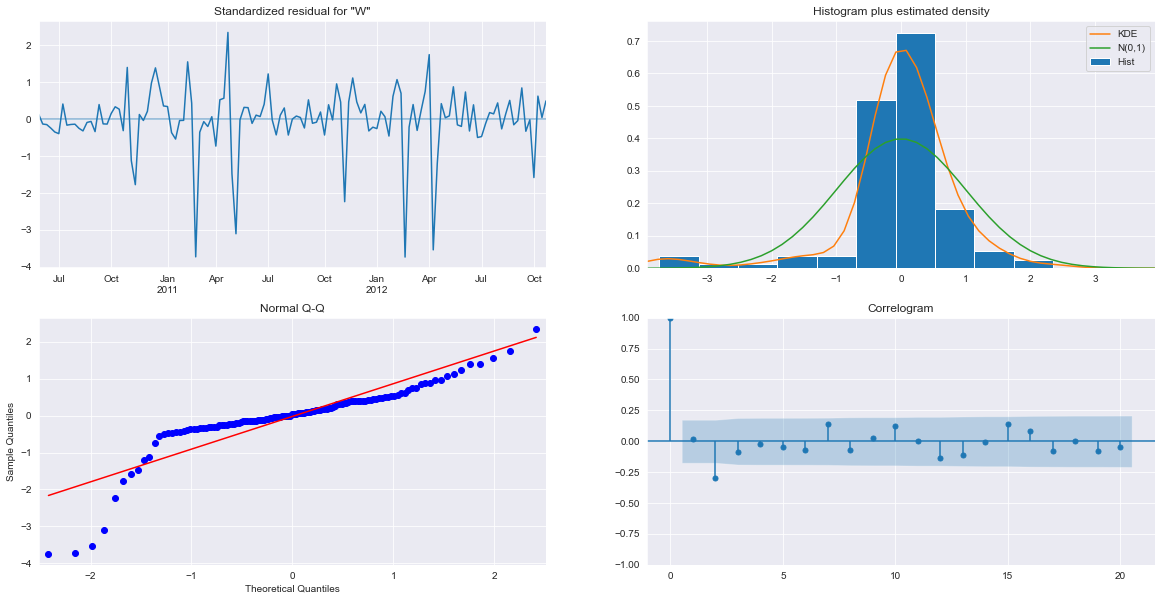

In [114]:
model.plot_diagnostics(figsize=(20,10),lags=20)
plt.show()